# Pocket Type Estimator
Let's train estimator which will assess each binding residue embedding as part of cryptic or non-cryptic pocket.


In [152]:
import numpy as np
import csv

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from sklearn.utils import class_weight
from sklearn import metrics

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load the data
Load the cryptic and non-cryptic binding residue's embeddings.

In [153]:
# TODO: update this
class ResidueLevelDataset(Dataset):
    def __init__(self, cryptic_embeddings, noncryptic_embeddings):
        # annotations
        annotations = np.concatenate((np.zeros(len(cryptic_embeddings)), np.ones(len(noncryptic_embeddings))))

        # concatenate dataset
        embeddings = np.concatenate((cryptic_embeddings, noncryptic_embeddings), axis=0)

        self.Ys = torch.tensor(annotations, dtype=torch.int16)
        self.Xs = torch.tensor(embeddings, dtype=torch.float32)


    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


In [237]:
def parse_annotations(annotation_paths):
    annotations = {}
    for annotation_path in annotation_paths:
        with open(annotation_path) as f:
            reader = csv.reader(f, delimiter=";")
            for row in reader:
                id = row[0].lower() + row[1]

                if len(row[3]) == 0 or id == '7ndlB': continue

                annotation = [int(residue.split('_')[1][1:]) for residue in row[3].split(' ')]
                annotations[id] = annotation
    return annotations

def get_embeddings(embeddings_path, indices, aggregate_per_protein=False):
    embeddings = None
    for id in indices.keys():
        if len(indices[id]) == 0: continue
        filename = id + '.npy'
        embedding = np.load(f'{embeddings_path}/{filename}')
        embedding = np.take(embedding, indices[id], axis=0)

        if aggregate_per_protein: embedding = np.mean(embedding, axis=0)

        if embeddings is None: embeddings = embedding
        else: 
            embeddings = np.vstack((embeddings,embedding))
        
    return embeddings
    

def process_dataset(cryptic_annotation_path, noncryptic_annotation_path, embeddings_path, remove_ambiguous=True, aggregate_per_protein=False):

    cryptic_indices = parse_annotations(cryptic_annotation_path)
    noncryptic_indices = parse_annotations(noncryptic_annotation_path)

    # some residues can be annotated as both cryptic and non-cryptic
    if remove_ambiguous:
        for id in noncryptic_indices.keys():
            exclusively_noncryptic_indices = list(set(noncryptic_indices[id]) - set(cryptic_indices[id]))
        #    if len(exclusively_noncryptic_indices) / len(noncryptic_indices[id]) > 0.75: noncryptic_indices[id] = []
        #    else: 
            noncryptic_indices[id] = exclusively_noncryptic_indices

    cryptic_embeddings = get_embeddings(embeddings_path, cryptic_indices, aggregate_per_protein=aggregate_per_protein)
    noncryptic_embeddings = get_embeddings(embeddings_path, noncryptic_indices, aggregate_per_protein=aggregate_per_protein)
    
    return cryptic_embeddings, noncryptic_embeddings

In [161]:
TRAIN_NONCRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-0.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-1.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-2.csv',
]
TRAIN_CRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-0.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-1.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-2.csv',
]
TEST_NONCRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-3.csv'
]
TEST_CRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-3.csv'
    ]

EMBEDDING_PATH = '/home/skrhakv/apolo/data/embeddings/cryptobench-v2/cryptobench-ahojv2-cut'

train_cryptic_embeddings, train_noncryptic_embeddings = process_dataset(TRAIN_CRYPTIC_ANNOTATION_PATH, TRAIN_NONCRYPTIC_ANNOTATION_PATH, EMBEDDING_PATH)
train_dataset = ResidueLevelDataset(train_cryptic_embeddings, train_noncryptic_embeddings)

test_cryptic_embeddings, test_noncryptic_embeddings = process_dataset(TEST_CRYPTIC_ANNOTATION_PATH, TEST_NONCRYPTIC_ANNOTATION_PATH, EMBEDDING_PATH)
test_dataset = ResidueLevelDataset(test_cryptic_embeddings, test_noncryptic_embeddings)

## Model
Define a model for distinguishing between cryptic and non-cryptic binding sites.

In [230]:
DROPOUT = 0.5
LAYER_WIDTH = 100
ESM2_DIM = 2560
class PocketTypeEstimator(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


In [213]:
def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

In [219]:
def evaluate(test_dataset, model, loss_fn, roc_curve=False):
    X_test, y_test = test_dataset[:]
    X_test, y_test = X_test.to(device), y_test.to(device).float()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if roc_curve:
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    return test_loss, test_acc, roc_auc, mcc


def run(train_dataset, test_dataset, run_evaluation=True, epochs=60):
    model_0 = PocketTypeEstimator().to(device)

    # Create an optimizer
    optimizer = torch.optim.Adam(params=model_0.parameters(),
                                lr=0.0001)

    X_train, y_train = train_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    positive_weight = get_class_weights(y_train.numpy())
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(positive_weight, dtype=torch.float16))

    X_train, y_train = X_train.to(device), y_train.to(device).float()

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        ### TRAIN
        model_0.train()

        y_logits = model_0(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits,
                       y_train)
        acc = accuracy_fn(y_true=y_train,
                          y_pred=y_pred)

        train_losses.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        ### TEST
        if run_evaluation:
            test_loss, acc, roc_auc, mcc = evaluate(test_dataset, model_0, loss_fn)
            test_losses.append(test_loss.cpu().detach().numpy())

            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")


    return train_losses, test_losses, model_0, loss_fn

## Validation
Find optimal number of epochs.

Epoch: 0 | Loss: 2.29117, Accuracy: 51.09% | Test loss: 1.06046, AUC: 0.5377544954296254, MCC: 0.05293399896529643
Epoch: 10 | Loss: 1.52874, Accuracy: 58.24% | Test loss: 0.91685, AUC: 0.6166691013205563, MCC: 0.16294696628019045
Epoch: 20 | Loss: 1.14287, Accuracy: 60.98% | Test loss: 0.87003, AUC: 0.6375988257770144, MCC: 0.19094533693603083
Epoch: 30 | Loss: 0.97713, Accuracy: 61.59% | Test loss: 0.85639, AUC: 0.6454979015400563, MCC: 0.20409519278871377
Epoch: 40 | Loss: 0.89217, Accuracy: 62.66% | Test loss: 0.85173, AUC: 0.6532623938702613, MCC: 0.21731544345988085
Epoch: 50 | Loss: 0.83853, Accuracy: 63.64% | Test loss: 0.84776, AUC: 0.6604748337237248, MCC: 0.2295392431049001


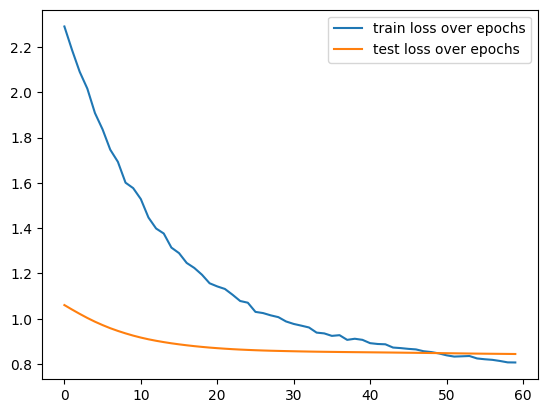

In [245]:
train_losses, test_losses, _, _ = run(train_dataset, test_dataset, epochs=60)

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()

In [238]:
TRAIN_NONCRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-0.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-1.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-2.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/train-fold-3.csv'
]
TRAIN_CRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-0.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-1.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-2.csv',
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/train-fold-3.csv'
]
TEST_NONCRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-noncryptic-translated-annotations/test.csv'
]
TEST_CRYPTIC_ANNOTATION_PATH = [
    '/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/test.csv'
    ]

EMBEDDING_PATH = '/home/skrhakv/apolo/data/embeddings/cryptobench-v2/cryptobench-ahojv2-cut'

train_cryptic_embeddings, train_noncryptic_embeddings = process_dataset(TRAIN_CRYPTIC_ANNOTATION_PATH, TRAIN_NONCRYPTIC_ANNOTATION_PATH, EMBEDDING_PATH)
train_dataset = ResidueLevelDataset(train_cryptic_embeddings, train_noncryptic_embeddings)

test_cryptic_embeddings, test_noncryptic_embeddings = process_dataset(TEST_CRYPTIC_ANNOTATION_PATH, TEST_NONCRYPTIC_ANNOTATION_PATH, EMBEDDING_PATH)
test_dataset = ResidueLevelDataset(test_cryptic_embeddings, test_noncryptic_embeddings)



In [239]:
print(torch.sum(train_dataset.Ys))
len(train_dataset.Ys) - torch.sum(train_dataset.Ys)


tensor(8546)


tensor(16107)

In [248]:
train_losses, test_losses, model, loss_fn = run(train_dataset, test_dataset, run_evaluation=False)

## ROC curve

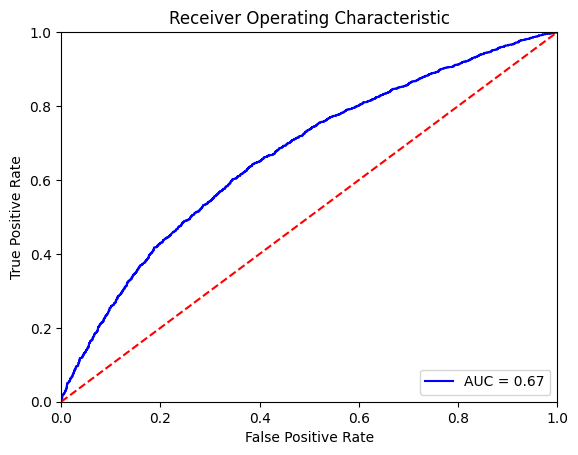

(tensor(0.8437, device='cuda:0'),
 64.73259334006055,
 0.6680360218686964,
 0.23575863538371133)

In [249]:
evaluate(test_dataset, model, loss_fn, roc_curve=True)

## Stats

In [243]:
from sklearn.metrics import confusion_matrix
def predict(model, test_dataset, threshold):
    X_test, y_test = test_dataset[:]
    X_test, y_test = X_test.to(device), y_test.to(device).float()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.tensor(torch.sigmoid(test_logits) > threshold, dtype=torch.int16)

    return test_pred.cpu().numpy()

pred_y = predict(model, test_dataset, threshold=0.5)
actual_y = test_dataset.Ys.numpy()
print('No. of NON-CRYPTIC: ', np.sum(actual_y))
print('No. of CRYPTIC: ', len(actual_y) - np.sum(actual_y))
print(confusion_matrix(actual_y, pred_y))

No. of NON-CRYPTIC:  1990
No. of CRYPTIC:  3956


/tmp/slurm.105030/ipykernel_2766799/538506119.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_pred = torch.tensor(torch.sigmoid(test_logits) > threshold, dtype=torch.int16)


array([[2775, 1181],
       [ 896, 1094]])